## 1. Setup and Load Data

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings

# Specific model libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Evaluation metrics & Model Selection
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Ignore harmless warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_theme(style="whitegrid")

In [2]:
# Load the cleaned dataset from Milestone 1
file_path = 'cleaned_retail_data_milestone1.csv'
df = pd.read_csv(file_path, parse_dates=['Date'])

## 2. Data Preparation for Modeling
### 2.1 SARIMA Data

In [3]:
# Aggregate total daily sales.
daily_sales_agg = df.groupby('Date')['Units Sold'].sum().reset_index()
daily_sales_sarima = daily_sales_agg.set_index('Date')['Units Sold']
daily_sales_sarima.head()

Date
2022-01-01    14484
2022-01-02    13415
2022-01-03    13681
2022-01-04    14084
2022-01-05    12572
Name: Units Sold, dtype: int64

### 2.2 Random Forest & XGBoost Data

In [4]:
# Calculate aggregate daily features from the original df
df['Revenue'] = df['Price'] * df['Units Sold']
daily_agg_features = df.groupby('Date').agg(
    TotalUnitsSold=('Units Sold', 'sum'),
    AvgPrice=('Price', 'mean'), # Average price of items sold that day
    AvgDiscount=('Discount', 'mean'), # Average discount offered that day
    AvgCompetitorPrice=('Competitor Pricing', 'mean'),
    TotalUnitsOrdered=('Units Ordered', 'sum'),
    AvgInventoryLevel=('Inventory Level', 'mean'),
    PromotionDay=('Holiday/Promotion', 'max')
).reset_index()

print("\nAggregated Daily Features for RF/XGBoost (Head):")
daily_agg_features


Aggregated Daily Features for RF/XGBoost (Head):


,Date,TotalUnitsSold,AvgPrice,AvgDiscount,AvgCompetitorPrice,TotalUnitsOrdered,AvgInventoryLevel,PromotionDay
0,2022-01-01,14484,57.5157,10.65,58.1831,10921,284.24,1
1,2022-01-02,13415,60.6365,9.80,60.2371,10770,272.50,1
2,2022-01-03,13681,56.7993,8.85,56.8813,11096,272.69,1
3,2022-01-04,14084,52.9930,10.60,52.8153,11572,275.88,1
4,2022-01-05,12572,55.9958,10.40,56.0426,10919,286.80,1
...,...,...,...,...,...,...,...,...
726,2023-12-28,16271,58.3097,10.00,58.3912,10077,287.94,1
727,2023-12-29,13368,56.2386,9.90,56.1972,11075,259.06,1
728,2023-12-30,13156,60.7218,10.65,60.7629,11224,257.83,1
729,2023-12-31,11208,59.2518,8.70,59.5656,10685,249.62,1


In [5]:
# Feature Engineering Function
def create_features(df_in):
    """Creates time series features from Date column"""
    df_out = df_in.copy()
    df_out['Date'] = pd.to_datetime(df_out['Date']) # Ensure Date is datetime
    df_out['DayOfWeek'] = df_out['Date'].dt.dayofweek
    df_out['Month'] = df_out['Date'].dt.month
    df_out['Year'] = df_out['Date'].dt.year
    df_out['DayOfYear'] = df_out['Date'].dt.dayofyear
    df_out['DayOfMonth'] = df_out['Date'].dt.day
    df_out['WeekOfYear'] = df_out['Date'].dt.isocalendar().week.astype(int)
    df_out['Quarter'] = df_out['Date'].dt.quarter

    # Lag features for the target variable 'TotalUnitsSold'
    target = 'TotalUnitsSold'
    df_out[f'{target}_lag_7'] = df_out[target].shift(7)
    df_out[f'{target}_lag_14'] = df_out[target].shift(14)
    df_out[f'{target}_lag_28'] = df_out[target].shift(28)
    
    # Rolling window features
    df_out[f'{target}_roll_mean_7'] = df_out[target].shift(1).rolling(window=7).mean() # Use shift(1) to prevent data leakage
    df_out[f'{target}_roll_std_7'] = df_out[target].shift(1).rolling(window=7).std()

    df_out = df_out.set_index('Date') # Set index for splitting
    return df_out

In [6]:
# Apply feature engineering
df_ml_features = create_features(daily_agg_features)

# Drop rows with NaN values created by lags/rolling features
df_ml_features = df_ml_features.dropna()

print("\nData with Engineered Features for RF/XGBoost (Head):")
df_ml_features.sort_index().head(10)


Data with Engineered Features for RF/XGBoost (Head):


,TotalUnitsSold,AvgPrice,AvgDiscount,AvgCompetitorPrice,TotalUnitsOrdered,AvgInventoryLevel,PromotionDay,DayOfWeek,Month,Year,DayOfYear,DayOfMonth,WeekOfYear,Quarter,TotalUnitsSold_lag_7,TotalUnitsSold_lag_14,TotalUnitsSold_lag_28,TotalUnitsSold_roll_mean_7,TotalUnitsSold_roll_std_7
Date,,,,,,,,,,,,,,,,,,,
2022-01-29,13169,52.7574,10.65,52.6354,9857,279.63,1,5,1,2022,29,29,4,1,14830.0,13753.0,14484.0,13329.285714,1128.562170
2022-01-30,13994,58.0097,11.30,58.1821,11262,273.45,1,6,1,2022,30,30,4,1,12650.0,15603.0,13415.0,13092.000000,914.816193
2022-01-31,13187,55.2553,9.45,55.0981,10916,263.58,1,0,1,2022,31,31,5,1,11277.0,13139.0,13681.0,13284.000000,947.058956
2022-02-01,13852,52.2507,10.70,52.3570,10763,273.22,1,1,2,2022,32,1,5,1,13945.0,14079.0,14084.0,13556.857143,374.550143
2022-02-02,14547,52.2146,9.60,52.4650,11551,286.86,1,2,2,2022,33,2,5,1,13680.0,14047.0,12572.0,13543.571429,359.848513
2022-02-03,12774,54.1838,10.10,53.7434,11373,250.41,1,3,2,2022,34,3,5,1,13761.0,14594.0,12563.0,13667.428571,525.645272
2022-02-04,12904,54.5477,9.80,54.8315,11165,258.12,1,4,2,2022,35,4,5,1,13162.0,12646.0,11826.0,13526.428571,620.229758
2022-02-05,15101,53.6408,10.85,54.0554,11431,289.79,1,5,2,2022,36,5,5,1,13169.0,14830.0,13958.0,13489.571429,652.330401
2022-02-06,13927,54.6421,9.30,54.8274,12143,275.18,1,6,2,2022,37,6,5,1,13994.0,12650.0,15896.0,13765.571429,867.363218


## 3. Time Series Splitting

In [7]:
min_feature_date = df_ml_features.index.min()
max_feature_date = df_ml_features.index.max()
print(f"\nDate range after feature engineering: {min_feature_date} to {max_feature_date}")

split_date = min_feature_date + (max_feature_date - min_feature_date) * .8
split_date_dt = split_date

# SARIMA split
train_sarima = daily_sales_sarima.loc[daily_sales_sarima.index <= split_date_dt]
test_sarima = daily_sales_sarima.loc[daily_sales_sarima.index > split_date_dt]

# Get exact indices for SARIMA prediction range
test_start_index = test_sarima.index.min()
test_end_index = test_sarima.index.max()

# RF & XGBoost split
train_ml = df_ml_features.loc[df_ml_features.index <= split_date_dt]
test_ml = df_ml_features.loc[df_ml_features.index > split_date_dt]

# Define Features (X) and Target (y) for ML models
TARGET = 'TotalUnitsSold'
# Exclude the target itself and any future-leaking columns if created accidentally
FEATURES = [col for col in df_ml_features.columns if col != TARGET]

X_train_ml = train_ml[FEATURES]
y_train_ml = train_ml[TARGET]
X_test_ml = test_ml[FEATURES]
y_test_ml = test_ml[TARGET]


print(f"\nData Split Details:")
print(f"Split Date: {split_date}")
print(f"SARIMA Train Shape: {train_sarima.shape}, Test Shape: {test_sarima.shape}")
print(f"ML Train Shape: {train_ml.shape}, Test Shape: {test_ml.shape}")
print(f"ML Features: {FEATURES}")


Date range after feature engineering: 2022-01-29 00:00:00 to 2024-01-01 00:00:00

Data Split Details:
Split Date: 2023-08-13 14:24:00
SARIMA Train Shape: (590,), Test Shape: (141,)
ML Train Shape: (562, 19), Test Shape: (141, 19)
ML Features: ['AvgPrice', 'AvgDiscount', 'AvgCompetitorPrice', 'TotalUnitsOrdered', 'AvgInventoryLevel', 'PromotionDay', 'DayOfWeek', 'Month', 'Year', 'DayOfYear', 'DayOfMonth', 'WeekOfYear', 'Quarter', 'TotalUnitsSold_lag_7', 'TotalUnitsSold_lag_14', 'TotalUnitsSold_lag_28', 'TotalUnitsSold_roll_mean_7', 'TotalUnitsSold_roll_std_7']


## 4. Model Training and Baseline Evaluation

In [8]:
# Dictionary to store results
model_results = {}
predictions = {} # Store predictions for plotting

### 4.1 SARIMA Model

In [9]:
print("\n--- Training SARIMA Model ---")

model_sarima = SARIMAX(train_sarima)
sarima_fit = model_sarima.fit()

# Forecast
forecast_sarima = sarima_fit.predict(start=test_start_index, end=test_end_index)
predictions['SARIMA'] = forecast_sarima

# Evaluate
mae_sarima = mean_absolute_error(test_sarima, forecast_sarima)
rmse_sarima = np.sqrt(mean_squared_error(test_sarima, forecast_sarima))
model_results['SARIMA'] = {'MAE': mae_sarima, 'RMSE': rmse_sarima, 'model': sarima_fit}
print(f"SARIMA - MAE: {mae_sarima:.2f}, RMSE: {rmse_sarima:.2f}")


--- Training SARIMA Model ---
SARIMA - MAE: 3964.52, RMSE: 4552.99


### 4.2 Random Forest Model

In [10]:
print("\n--- Training Random Forest Model ---")
model_rf = RandomForestRegressor(n_estimators=100, # Number of trees
                                 random_state=42,
                                 max_depth=10,     # Limit tree depth
                                 min_samples_split=10 # Min samples to split node
                                )
model_rf.fit(X_train_ml, y_train_ml)

# Predict
forecast_rf = model_rf.predict(X_test_ml)
predictions['Random Forest'] = pd.Series(forecast_rf, index=X_test_ml.index)

# Evaluate
mae_rf = mean_absolute_error(y_test_ml, forecast_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_ml, forecast_rf))
model_results['Random Forest'] = {'MAE': mae_rf, 'RMSE': rmse_rf, 'model': model_rf}
print(f"Random Forest - MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}")


--- Training Random Forest Model ---
Random Forest - MAE: 688.46, RMSE: 854.39


### 4.3 XGBoost Model

In [11]:
print("\n--- Training XGBoost Model ---")
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=1000,
                             learning_rate=0.01,
                             max_depth=5,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             random_state=42,
                             early_stopping_rounds=50,
                             n_jobs=-1)

model_xgb.fit(X_train_ml, y_train_ml,
              eval_set=[(X_test_ml, y_test_ml)],
              verbose=False) # Suppress verbose output during training

# Predict
forecast_xgb = model_xgb.predict(X_test_ml)
predictions['XGBoost'] = pd.Series(forecast_xgb, index=X_test_ml.index)


# Evaluate
mae_xgb = mean_absolute_error(y_test_ml, forecast_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test_ml, forecast_xgb))
model_results['XGBoost'] = {'MAE': mae_xgb, 'RMSE': rmse_xgb, 'model': model_xgb}
print(f"XGBoost - MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}")


--- Training XGBoost Model ---
XGBoost - MAE: 689.91, RMSE: 872.85


## 5. Model Comparison and Selection

In [12]:
print("\n--- Model Comparison ---")
results_list = []
for model_name, metrics in model_results.items():
    results_list.append({
        'Model': model_name,
        'MAE': metrics['MAE'],
        'RMSE': metrics['RMSE']
    })
results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values(by='RMSE') # Sort by RMSE (lower is better)

print("Baseline Model Performance Comparison (Test Set):")
print(results_df)


--- Model Comparison ---
Baseline Model Performance Comparison (Test Set):
           Model          MAE         RMSE
1  Random Forest   688.457802   854.387047
2        XGBoost   689.905212   872.846994
0         SARIMA  3964.515468  4552.994521


In [13]:
# Select the best model based on RMSE
best_model_name = results_df.iloc[0]['Model']
best_untuned_model_obj = model_results[best_model_name]['model']
best_untuned_rmse = results_df.iloc[0]['RMSE']
best_untuned_mae = results_df.iloc[0]['MAE'] # Store MAE too


print(f"\nBest Baseline Model: {best_model_name} (RMSE: {best_untuned_rmse:.2f})")


Best Baseline Model: Random Forest (RMSE: 854.39)


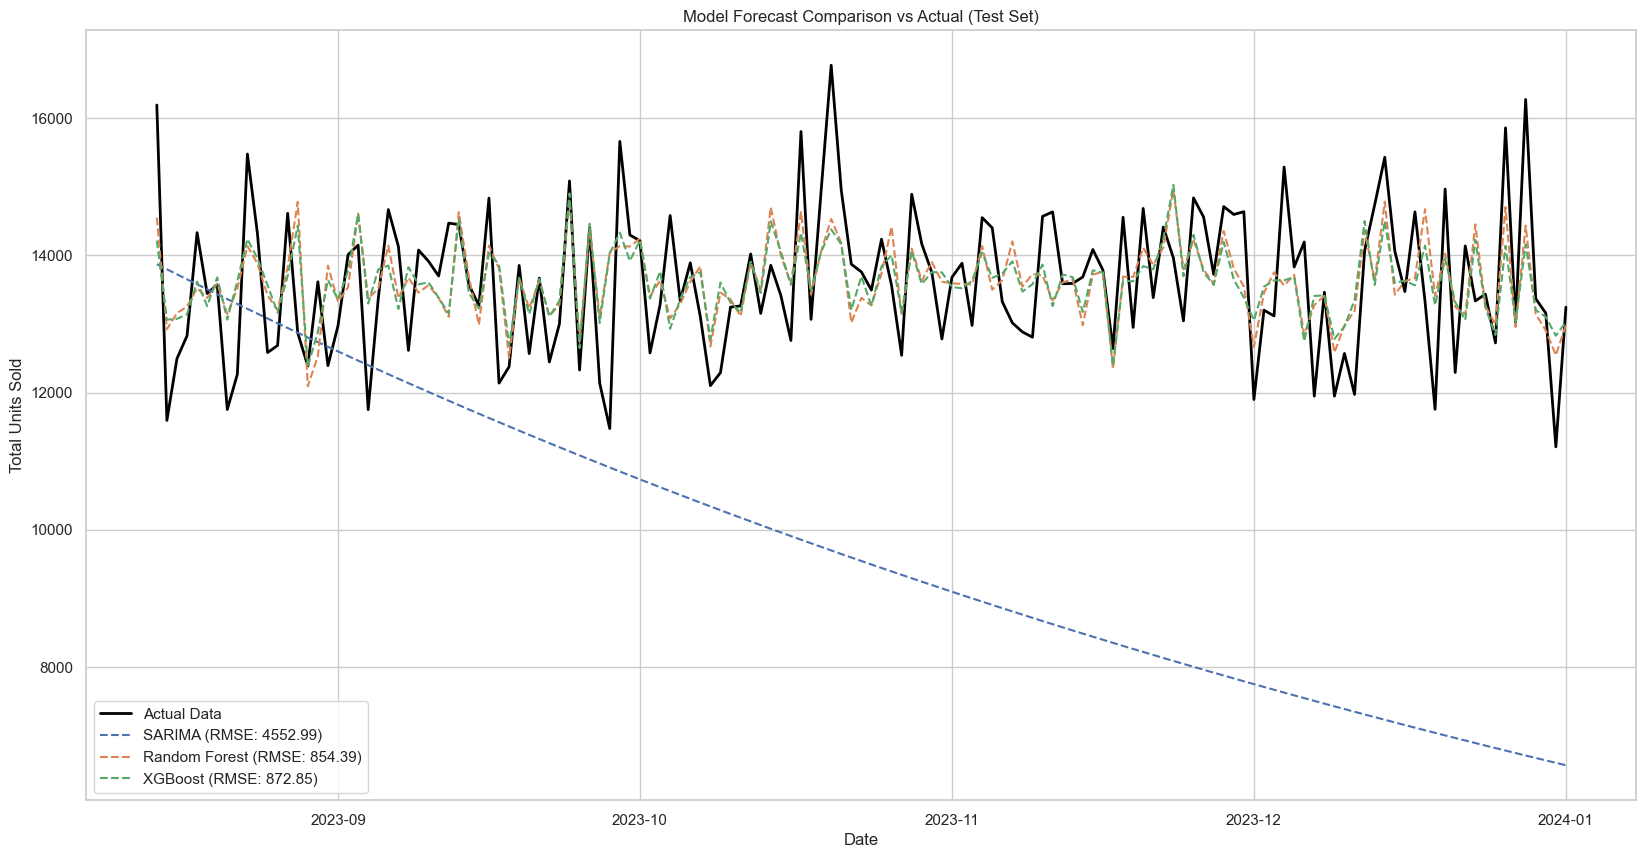

In [14]:
# --- Visualize Forecasts ---
plt.figure(figsize=(20, 10))
plt.plot(test_ml.index, y_test_ml, label='Actual Data', color='black', linewidth=2)

for model_name in predictions.keys():
    if predictions[model_name] is not None:
        rmse_val = model_results[model_name]['RMSE']
        plt.plot(predictions[model_name].index, predictions[model_name], label=f'{model_name} (RMSE: {rmse_val:.2f})', linestyle='--')

plt.title('Model Forecast Comparison vs Actual (Test Set)')
plt.xlabel('Date')
plt.ylabel('Total Units Sold')
plt.legend()
plt.show()

## 6. Hyperparameter Tuning (for the selected best model)

In [15]:
print(f"\n--- Hyperparameter Tuning for {best_model_name} ---")


# Use TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=3)

print("Tuning Random Forest using GridSearchCV...")
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, None],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 5]
}
# Instantiate the grid search model
grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
                                param_grid=param_grid_rf,
                                cv=tscv,
                                scoring='neg_root_mean_squared_error',
                                verbose=1)

# Fit the grid search to the data
grid_search_rf.fit(X_train_ml, y_train_ml)
print(f"Best RF Tuned Params: {grid_search_rf.best_params_}")
tuned_model_obj = grid_search_rf.best_estimator_

# Evaluate tuned model
forecast_tuned_rf = tuned_model_obj.predict(X_test_ml)
tuned_mae = mean_absolute_error(y_test_ml, forecast_tuned_rf)
tuned_rmse = np.sqrt(mean_squared_error(y_test_ml, forecast_tuned_rf))
print(f"Best RF Tuned MAE: {tuned_mae:.2f}")
print(f"Best RF Tuned RMSE: {tuned_rmse:.2f}")


--- Hyperparameter Tuning for Random Forest ---
Tuning Random Forest using GridSearchCV...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best RF Tuned Params: {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 200}
Best RF Tuned MAE: 684.21
Best RF Tuned RMSE: 851.75


## 7. Tuned Model Comparison

In [16]:
print("\n--- Tuned vs. Untuned Model Comparison ---")
print(f"Untuned {best_model_name} RMSE: {best_untuned_rmse:.2f}, MAE: {best_untuned_mae:.2f}")
print(f"Tuned {best_model_name} RMSE: {tuned_rmse:.2f}, MAE: {tuned_mae:.2f}")

final_model_obj = best_untuned_model_obj
final_model_name = f"{best_model_name}_untuned"
final_rmse = best_untuned_rmse
final_mae = best_untuned_mae
final_predictions = predictions[best_model_name] # Get untuned predictions

# Update if tuned model is better
if tuned_rmse < best_untuned_rmse:
    print(f"\nTuned {best_model_name} performed better.")
    final_model_obj = tuned_model_obj
    final_model_name = f"{best_model_name}_tuned"
    final_rmse = tuned_rmse
    final_mae = tuned_mae

    # Get predictions from the tuned model for the final plot
    if best_model_name == 'Random Forest':
         final_predictions = pd.Series(tuned_model_obj.predict(X_test_ml), index=X_test_ml.index)

    elif best_model_name == 'XGBoost':
         final_predictions = pd.Series(tuned_model_obj.predict(X_test_ml), index=X_test_ml.index)

else:
    print(f"\nUntuned {best_model_name} performed better or tuning did not improve results significantly.")



--- Tuned vs. Untuned Model Comparison ---
Untuned Random Forest RMSE: 854.39, MAE: 688.46
Tuned Random Forest RMSE: 851.75, MAE: 684.21

Tuned Random Forest performed better.


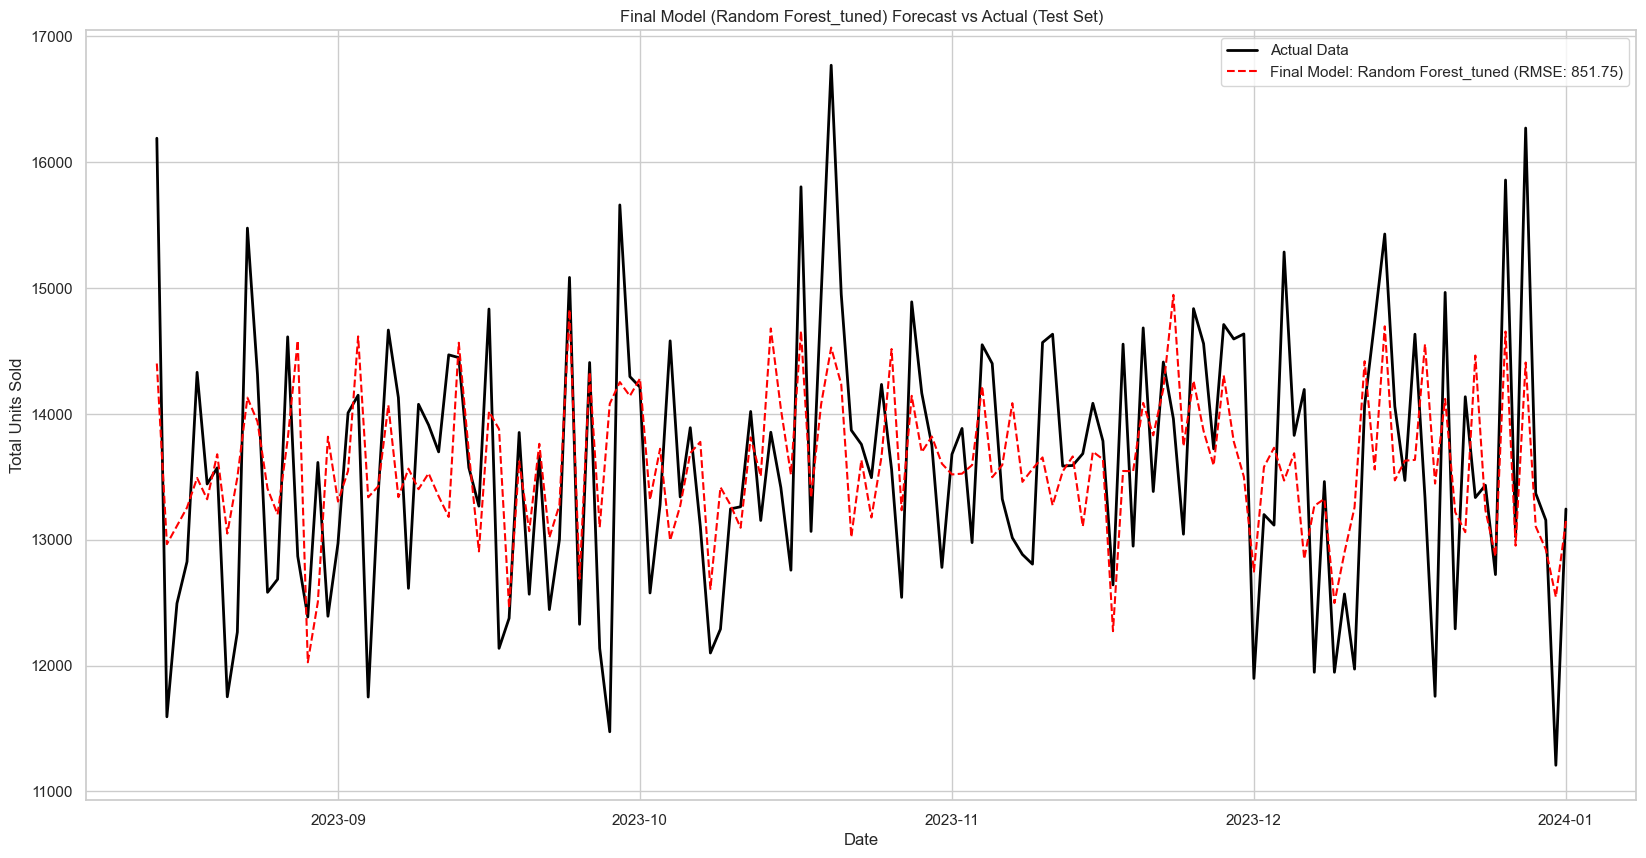

In [17]:
# --- Visualize Final Model Forecast ---
plt.figure(figsize=(20, 10))
plt.plot(test_ml.index, y_test_ml, label='Actual Data', color='black', linewidth=2)
plt.plot(final_predictions.index, final_predictions, label=f'Final Model: {final_model_name} (RMSE: {final_rmse:.2f})', color='red', linestyle='--')
plt.title(f'Final Model ({final_model_name}) Forecast vs Actual (Test Set)')
plt.xlabel('Date')
plt.ylabel('Total Units Sold')
plt.legend()
plt.show()

## 8. Final Model Selection and Saving

In [18]:
print(f"\n--- Final Model Selection ---")
print(f"Selected Final Model: {final_model_name}")
print(f"Final Model RMSE on Test Set: {final_rmse:.2f}")
print(f"Final Model MAE on Test Set: {final_mae:.2f}")

# Save the selected final model object
final_model_filename = 'sales_forecasting_final_model.pkl'
with open(final_model_filename, 'wb') as f:
    pickle.dump(final_model_obj, f)

print(f"\nFinal selected model ({final_model_name}) saved as {final_model_filename}")


--- Final Model Selection ---
Selected Final Model: Random Forest_tuned
Final Model RMSE on Test Set: 851.75
Final Model MAE on Test Set: 684.21

Final selected model (Random Forest_tuned) saved as sales_forecasting_final_model.pkl


## 9. Milestone 3 Summary

In this milestone, we developed, compared, and optimized forecasting models:
1.  **Data Preparation:** Aggregated total daily sales. Prepared data formats for SARIMA (univariate series) and feature-based models (RF, XGBoost). Engineered time-based, lag, and aggregate daily features for RF/XGBoost.
2.  **Time Series Split:** Split data chronologically for training and testing across all model formats.
3.  **Model Training & Baseline Evaluation:** Trained SARIMA, Random Forest, and XGBoost models on training data and evaluated their baseline performance (MAE, RMSE) on the test set.
4.  **Model Comparison:** Compared the baseline performance of the models using metrics and visualizations. Selected the best baseline model (`{best_model_name}`) based primarily on RMSE.
5.  **Hyperparameter Tuning:** Performed hyperparameter tuning using `GridSearchCV` with `TimeSeriesSplit` for the best baseline model (`{best_model_name}`). SARIMA tuning was noted as complex and skipped automated search.
6.  **Tuned vs. Untuned:** Compared the performance of the tuned model against its untuned version, selecting the better of the two based on test set RMSE.
7.  **Final Model Selection:** Selected the overall best model (`{final_model_name}`) after considering baseline performance and tuning results.
8.  **Model Saving:** Saved the final selected model (`{final_model_name}`) using pickle for deployment in Milestone 4.

This process provides a robust approach to selecting and optimizing a forecasting model by comparing different methodologies and leveraging relevant features from the dataset. The final saved model represents the best effort from this stage.